<a href="https://colab.research.google.com/github/JALVARADORUIZ/Magister_BigData_UB/blob/main/M7_AG1_Grupo14_versionpaula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
tqdm.pandas()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import nltk
from nltk.corpus import stopwords 
from collections import Counter
nltk.download('stopwords')


from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import random
random.seed(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
reviews_file = "https://raw.githubusercontent.com/albertojulian/master-ub/main/reviews.txt"
labels_file = "https://raw.githubusercontent.com/albertojulian/master-ub/main/labels.txt"

In [ ]:
df_reviews = pd.read_csv(reviews_file,header=None, names=['review'])
df_labels = pd.read_csv(labels_file, header=None, names=['sentiment'])

df = pd.concat([df_reviews,df_labels],axis=1)

In [ ]:
df.head()

,review,sentiment
0,bromwell high is a cartoon comedy . it ran at ...,positive
1,story of a man who has unnatural feelings for ...,negative
2,homelessness or houselessness as george carli...,positive
3,airport starts as a brand new luxury pla...,negative
4,brilliant over acting by lesley ann warren . ...,positive


In [ ]:
df['sentiment'].value_counts()

positive    12500
negative    12500
Name: sentiment, dtype: int64

# **PREPROCESAMIENTO**

### Eliminar signos que no sean alfanuméricos.



In [ ]:
def preprocess_string(s):
    # Eliminar todos los caracteres que no sean palabras (todo excepto números y letras)
    s = re.sub(r"[^\w\s]", '', s)
    # Reemplazar todas las series de espacios en blanco sin espacio
    s = re.sub(r"\s+", '', s)
    # reemplazar dígitos sin espacio
    s = re.sub(r"\d", '', s)

    return s

In [ ]:
for sentence in df.review:
    for word in sentence.split():
        word = preprocess_string(word)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.1)

In [ ]:
tr_texts, y_train = df_train["review"].tolist(), df_train["sentiment"].tolist()
te_texts, y_test =  df_test["review"].tolist(), df_test["sentiment"].tolist()

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
max_features = 20000
max_text_length = 160
validation_split = 0.1
embedding_size = 100

def plot_text_lenth_histogram(sequences):
  freqs = Counter()
  for seq in sequences:
    freqs[len(seq)] += 1

  labels, values = zip(*freqs.items())

  indexes = np.arange(len(labels))
  width = 1

  plt.bar(indexes, values, width)
  #plt.xticks(indexes + width * 0.5, labels)
  plt.show()

# función para añadir símbolo especial de inicio de frase
def addBeginSeqSymbol(sequences): 
    newSeqs = []
    for seq in sequences:
        newSeqs.append([1] + [value+1 for value in seq])
    newSeqs = np.array(newSeqs)
    return newSeqs

def shuffle_partition(tr_texts, y_train):
    instances = list(zip(tr_texts, y_train))
    random.shuffle(instances)
    new_tr_texts, new_y_train = [], []
    for (text, label) in instances:
        new_tr_texts.append(text)
        new_y_train.append(label)
    return new_tr_texts, np.array(new_y_train) 

# función para borrar repeticiones de una partición
def removeInstanceRepetitionsFromPartition(tr_texts, y_train):
    new_tr_texts, new_y_train, seen = [], [], set()
    for text, label in zip(tr_texts, y_train):
        if text not in seen:
            new_tr_texts.append(text)
            new_y_train.append(label)
            seen.add(text)
    return new_tr_texts, np.array(new_y_train)

# función para dividir una partición de training en training+dev
def divide_training_into_tr_and_dev(tr_texts, y_train, validation_split):
    # cuenta las frecuencias de las instancias
    text2freq = Counter()
    for text in tr_texts:
        text2freq[text] += 1

    # borrar repeticiones de las instancias y hacer shuffle
    tr_texts_aux, y_train_aux = removeInstanceRepetitionsFromPartition(tr_texts, y_train)
    tr_texts_aux, y_train_aux = shuffle_partition(tr_texts_aux, y_train_aux)

    # seleccionar instancias de dev
    tr_instances_aux = list(zip(tr_texts_aux, y_train_aux))
    split_point = int(len(tr_instances_aux)*validation_split)
    dev_instances = tr_instances_aux[:split_point]

    # restaurar frecuencias de instancias originales
    dev_texts, y_dev = [], []
    for (text, label) in dev_instances:
        for i in range(text2freq[text]):
            dev_texts.append(text)
            y_dev.append(label)

    # crear nuevo training filtrando el dev
    dev_texts_set = set(dev_texts)
    new_tr_texts, new_y_train = [], []
    for (text, label) in zip(tr_texts, y_train):
        if text not in dev_texts_set:
            new_tr_texts.append(text)
            new_y_train.append(label)

    return new_tr_texts, np.array(new_y_train), dev_texts, np.array(y_dev)

Vectorizing...


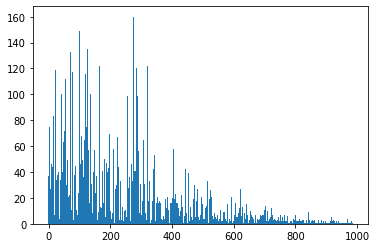

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Padding sequences (samples x time)...
20252 train sequences
2248 dev sequences
2500 test sequences


In [ ]:
# dividimos el training en training+dev (90-10% split)
tr_texts_90, y_train_90, dev_texts_10, y_dev_10 = divide_training_into_tr_and_dev(tr_texts, y_train, validation_split)

print("Vectorizing...")
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(tr_texts_90)
# convertimos las instancias en arrays de ID de palabra
tr_sequences = tokenizer.texts_to_sequences(tr_texts_90)  
dev_sequences = tokenizer.texts_to_sequences(dev_texts_10)       
te_sequences = tokenizer.texts_to_sequences(te_texts)

# muestra histograma de longitud de textos, si quieres jugar con el valor de "max_text_length"
plot_text_lenth_histogram(tr_sequences)

# anadimos símbolo de inicio de frase
tr_sequences = addBeginSeqSymbol(tr_sequences) # vamos a empezar todas las secuencias con el símbolo reservado 1. +1 al resto de IDs, para hacerlo único a este propósito
dev_sequences = addBeginSeqSymbol(dev_sequences) 
te_sequences = addBeginSeqSymbol(te_sequences) 
word_index = {k: v+1 for k, v in tokenizer.word_index.items() if v <= max_features} # +1 ya que el 0 está reservado para padding, y el 1 ya lo hemos reservado para el inicio de la secuencia
index_word = {v: k for k,v in word_index.items()}
max_features = max(word_index.values())+1 # +1 ya que la posición de max_features es también accesible via índice

# aplicamos el padding a las instancias, para que tocas ocupen el mismo tamaño y no haya problemas al convertir a embedding luego
print('Padding sequences (samples x time)...')
x_train = sequence.pad_sequences(tr_sequences, maxlen=max_text_length)
x_dev = sequence.pad_sequences(dev_sequences, maxlen=max_text_length)
x_test = sequence.pad_sequences(te_sequences, maxlen=max_text_length)
print(len(x_train), 'train sequences')
print(len(x_dev), 'dev sequences')
print(len(x_test), 'test sequences')

In [ ]:
glove = torchtext.vocab.GloVe(name='6B',dim=100)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.42MB/s]                           
100%|█████████▉| 399999/400000 [00:15<00:00, 25903.61it/s]


In [ ]:
def create_pretrained_embedding_matrix(num_words, embedding_size, index_word, embedding_model, vocab):
    embedding_matrix = np.zeros((num_words, embedding_size))
    for i, word in index_word.items():
        if word in vocab: # las palabras que no estén en el modelo de embeddings, estarán formadas inicialmente por embeddings con zeros
            embedding_matrix[i] = embedding_model[word]
    return embedding_matrix

In [ ]:
embedding_matrix = create_pretrained_embedding_matrix(max_features, embedding_size, index_word, glove.stoi, glove.itos) 
embedding_matrix = torch.from_numpy(embedding_matrix) # torch.float64

In [ ]:
# crear Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train_90))
valid_data = TensorDataset(torch.from_numpy(x_dev), torch.from_numpy(y_dev_10))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

batch_size = 128

# asegurate de barajar los datos al crear el data loader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [ ]:
# comprobamos si hay alguna GPU disponible
train_on_gpu = torch.cuda.is_available()

if(train_on_gpu):
    device = torch.device('cuda')
    print('Training on GPU.')
else:
    device = torch.device('cpu')
    print('No GPU available, training on CPU.')

Training on GPU.


In [ ]:
hidden_dim = embedding_size
hidden2_dim = int(embedding_size/2)
output_dim = 1 # si fueran datos categóricos (necesario cuando hay más de 2 clases), aquí iría el nº de clases
dropout = 0.1

class LSTM(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, hidden_dim, hidden2_dim,
               output_dim, dropout, device):
    super().__init__()

    self.output_size = output_dim
    self.hidden_dim = hidden_dim
    self.device = device

    self.embedding = nn.Embedding(vocabulary_size, embedding_size)

    self.lstm = nn.LSTM(embedding_size, hidden_dim, 
          dropout=dropout, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, hidden2_dim)
    self.fc2 = nn.Linear(hidden2_dim, output_dim)
    self.dropout = nn.Dropout(dropout)
    self.sig = nn.Sigmoid()

  def forward(self, x):

    x = self.embedding(x)

    x = x.float()

    lstm_out, hidden = self.lstm(x)
    lstm_out = lstm_out[:, -1, :]

    out = self.dropout(lstm_out)
    out = self.fc1(out)
    out = self.dropout(out)
    out = self.fc2(out)
    sig_out = self.sig(out)
    return sig_out

In [ ]:
# creamos el modelo de LSTM
model = LSTM(max_features, embedding_size, hidden_dim, hidden2_dim,
               output_dim, dropout, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
# definimos learning rate, loss function y optimizer
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
epochs = 15 # prueba a aumentar este número

counter = 0
clip = 5 # gradient clipping para prevenir exploding gradient 

# mover modelo a la GPU, si está disponible
if(train_on_gpu):
    model.cuda()

history = {"loss":[], "val_loss":[], "acc":[], "val_accuracy":[]}

model.train()
# entrenar X epoch
for e in range(epochs):

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero accumulated gradients
        model.zero_grad()
 
        # get the output from the model
        output = model(inputs)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    # loss stats
    # Get validation loss

    val_losses = []
    model.eval()
    num_correct = 0
    for inputs, labels in valid_loader:

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        output = model(inputs)
        val_loss = criterion(output.squeeze(), labels.float())
        val_losses.append(val_loss.item())

        # convert output probabilities to predicted class (0 or 1)
        pred = torch.round(output.squeeze())  # rounds to the nearest integer

        # compare predictions to true label
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)

    val_loss_mean = np.mean(val_losses)
    val_acc = 100*num_correct/len(valid_loader.dataset)

    model.train()
    print(f"Epoch: {e+1}/{epochs}...Step: {counter}...",
          f"Loss: {loss.item():.4f}...",
          f"Val Loss: {val_loss_mean:.4f}",
          f"Val Acc: {val_acc:.1f}%")
    
    history['loss'].append(loss.item())
    history['val_loss'].append(val_loss_mean)
    history['val_accuracy'].append(val_acc)

Epoch: 1/15...Step: 159... Loss: 0.5728... Val Loss: 0.5643 Val Acc: 70.5%
Epoch: 2/15...Step: 318... Loss: 0.3612... Val Loss: 0.4500 Val Acc: 79.0%
Epoch: 3/15...Step: 477... Loss: 0.4926... Val Loss: 0.4262 Val Acc: 80.5%
Epoch: 4/15...Step: 636... Loss: 0.4130... Val Loss: 0.3920 Val Acc: 83.9%
Epoch: 5/15...Step: 795... Loss: 0.1714... Val Loss: 0.3863 Val Acc: 84.1%
Epoch: 6/15...Step: 954... Loss: 0.7501... Val Loss: 0.4348 Val Acc: 84.5%
Epoch: 7/15...Step: 1113... Loss: 0.1355... Val Loss: 0.4185 Val Acc: 84.1%
Epoch: 8/15...Step: 1272... Loss: 0.1788... Val Loss: 0.4746 Val Acc: 84.6%
Epoch: 9/15...Step: 1431... Loss: 0.1946... Val Loss: 0.5711 Val Acc: 82.2%
Epoch: 10/15...Step: 1590... Loss: 0.3416... Val Loss: 0.5969 Val Acc: 84.4%
Epoch: 11/15...Step: 1749... Loss: 0.0085... Val Loss: 0.6544 Val Acc: 84.6%
Epoch: 12/15...Step: 1908... Loss: 0.0022... Val Loss: 0.7668 Val Acc: 84.9%
Epoch: 13/15...Step: 2067... Loss: 0.0049... Val Loss: 1.2580 Val Acc: 84.3%
Epoch: 14/15..

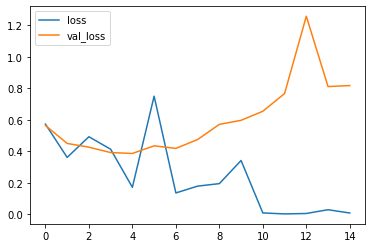

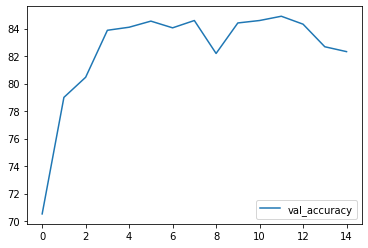

In [ ]:
# hagamos unos plot de cómo evoluciona el loss (training y val) y el accuracy (val)

import matplotlib.pyplot as plt
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.close()
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.close()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get test data loss and accuracy

test_losses = [] # track loss
y_pred = []

model.eval()
# iterate over test data
for inputs, labels in test_loader:

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output = model(inputs)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    y_pred.extend(pred.detach().numpy() if not train_on_gpu else pred.cpu().detach().numpy())

print("Test loss: {:.3f}".format(np.mean(test_losses)))

print("Summary of results:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Test loss: 0.820
Summary of results:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1216
           1       0.82      0.88      0.85      1284

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500

[[ 971  245]
 [ 158 1126]]
